In [1]:
# import the required packages
import pandas as pd
import numpy as np
import re

# Visuals
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
import matplotlib.dates as mdates
from datetime import datetime

import nltk
from collections import Counter
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from feature_engine.outliers import Winsorizer
from feature_engine.imputation import RandomSampleImputer

## Basic Time series forecasting (using estate_soe combined)

In [2]:
df = pd.read_excel('final data/estate_soe_combined_api.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36683 entries, 0 to 36682
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            36683 non-null  datetime64[ns]
 1   Block           36683 non-null  object        
 2   IRR Value W/m²  36683 non-null  float64       
 3   Energy kWh      36683 non-null  float64       
 4   PR %            36683 non-null  float64       
 5   Sensor ID       18861 non-null  object        
 6   Sensor Type     36683 non-null  object        
 7   Month           36683 non-null  int64         
 8   Day             36683 non-null  int64         
 9   humidity(%)     36683 non-null  float64       
 10  air temp        36683 non-null  float64       
 11  rain fall       36683 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(3)
memory usage: 3.4+ MB


In [4]:
df = df[df['Sensor Type'] == 'DPM']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19079 entries, 0 to 36682
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            19079 non-null  datetime64[ns]
 1   Block           19079 non-null  object        
 2   IRR Value W/m²  19079 non-null  float64       
 3   Energy kWh      19079 non-null  float64       
 4   PR %            19079 non-null  float64       
 5   Sensor ID       18861 non-null  object        
 6   Sensor Type     19079 non-null  object        
 7   Month           19079 non-null  int64         
 8   Day             19079 non-null  int64         
 9   humidity(%)     19079 non-null  float64       
 10  air temp        19079 non-null  float64       
 11  rain fall       19079 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(3)
memory usage: 1.9+ MB


In [5]:
df.head()

,Date,Block,IRR Value W/m²,Energy kWh,PR %,Sensor ID,Sensor Type,Month,Day,humidity(%),air temp,rain fall
0,2021-01-01,72,1154.274,41.210,80.00,DPM-599489-01,DPM,1,1,89.582452,24.670825,0.058947
1,2021-01-02,72,1154.274,26.352,80.00,DPM-599489-01,DPM,1,2,98.324167,28.606154,0.000000
2,2021-01-03,72,1154.274,67.860,80.00,DPM-599489-01,DPM,1,3,60.878473,28.379386,0.000000
3,2021-01-04,72,2440.595,126.320,80.03,DPM-599489-01,DPM,1,4,69.230882,26.554960,0.000000
4,2021-01-05,72,4479.086,235.240,81.21,DPM-599489-01,DPM,1,5,88.670588,26.203431,0.000000


#### setting index to date for forecasting

In [6]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

#### dropping redundant data

In [7]:
df.drop(['Sensor ID','Sensor Type','Month','Day'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19079 entries, 2021-01-01 to 2024-05-05
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Block           19079 non-null  object 
 1   IRR Value W/m²  19079 non-null  float64
 2   Energy kWh      19079 non-null  float64
 3   PR %            19079 non-null  float64
 4   humidity(%)     19079 non-null  float64
 5   air temp        19079 non-null  float64
 6   rain fall       19079 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.2+ MB


In [8]:
print((df['IRR Value W/m²']==0).sum())
print((df['PR %']==0).sum())

218
218


In [36]:
### values of 0 are from SOE panels

In [9]:
df.drop(['IRR Value W/m²', 'PR %'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19079 entries, 2021-01-01 to 2024-05-05
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Block        19079 non-null  object 
 1   Energy kWh   19079 non-null  float64
 2   humidity(%)  19079 non-null  float64
 3   air temp     19079 non-null  float64
 4   rain fall    19079 non-null  float64
dtypes: float64(4), object(1)
memory usage: 894.3+ KB


#### rid off SOE data, not significant in volume

In [10]:
df = df[df['Block'] != 'SOE']
df.drop(['Block'], axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18861 entries, 2021-01-01 to 2024-04-30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Energy kWh   18861 non-null  float64
 1   humidity(%)  18861 non-null  float64
 2   air temp     18861 non-null  float64
 3   rain fall    18861 non-null  float64
dtypes: float64(4)
memory usage: 736.8 KB


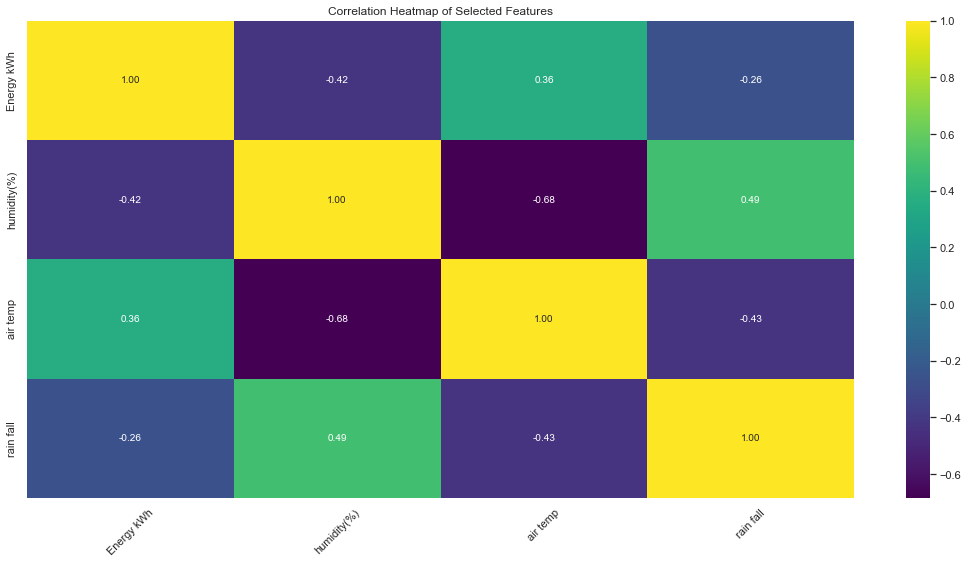

In [12]:
# corr matrix calculation
correlation_matrix = df.corr()

# plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', annot_kws={'size': 10})
plt.title('Correlation Heatmap of Selected Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
df_forecast = df.copy()
df_forecast = df_forecast.groupby(df_forecast.index).mean()


duplicate_dates = df_forecast.index.duplicated(keep=False)
if not duplicate_dates.any():
    print("All dates are unique after aggregation.")
else:
    print("There are still duplicate dates in the data.")

All dates are unique after aggregation.


#### exploring seasonality

<Figure size 576x576 with 0 Axes>

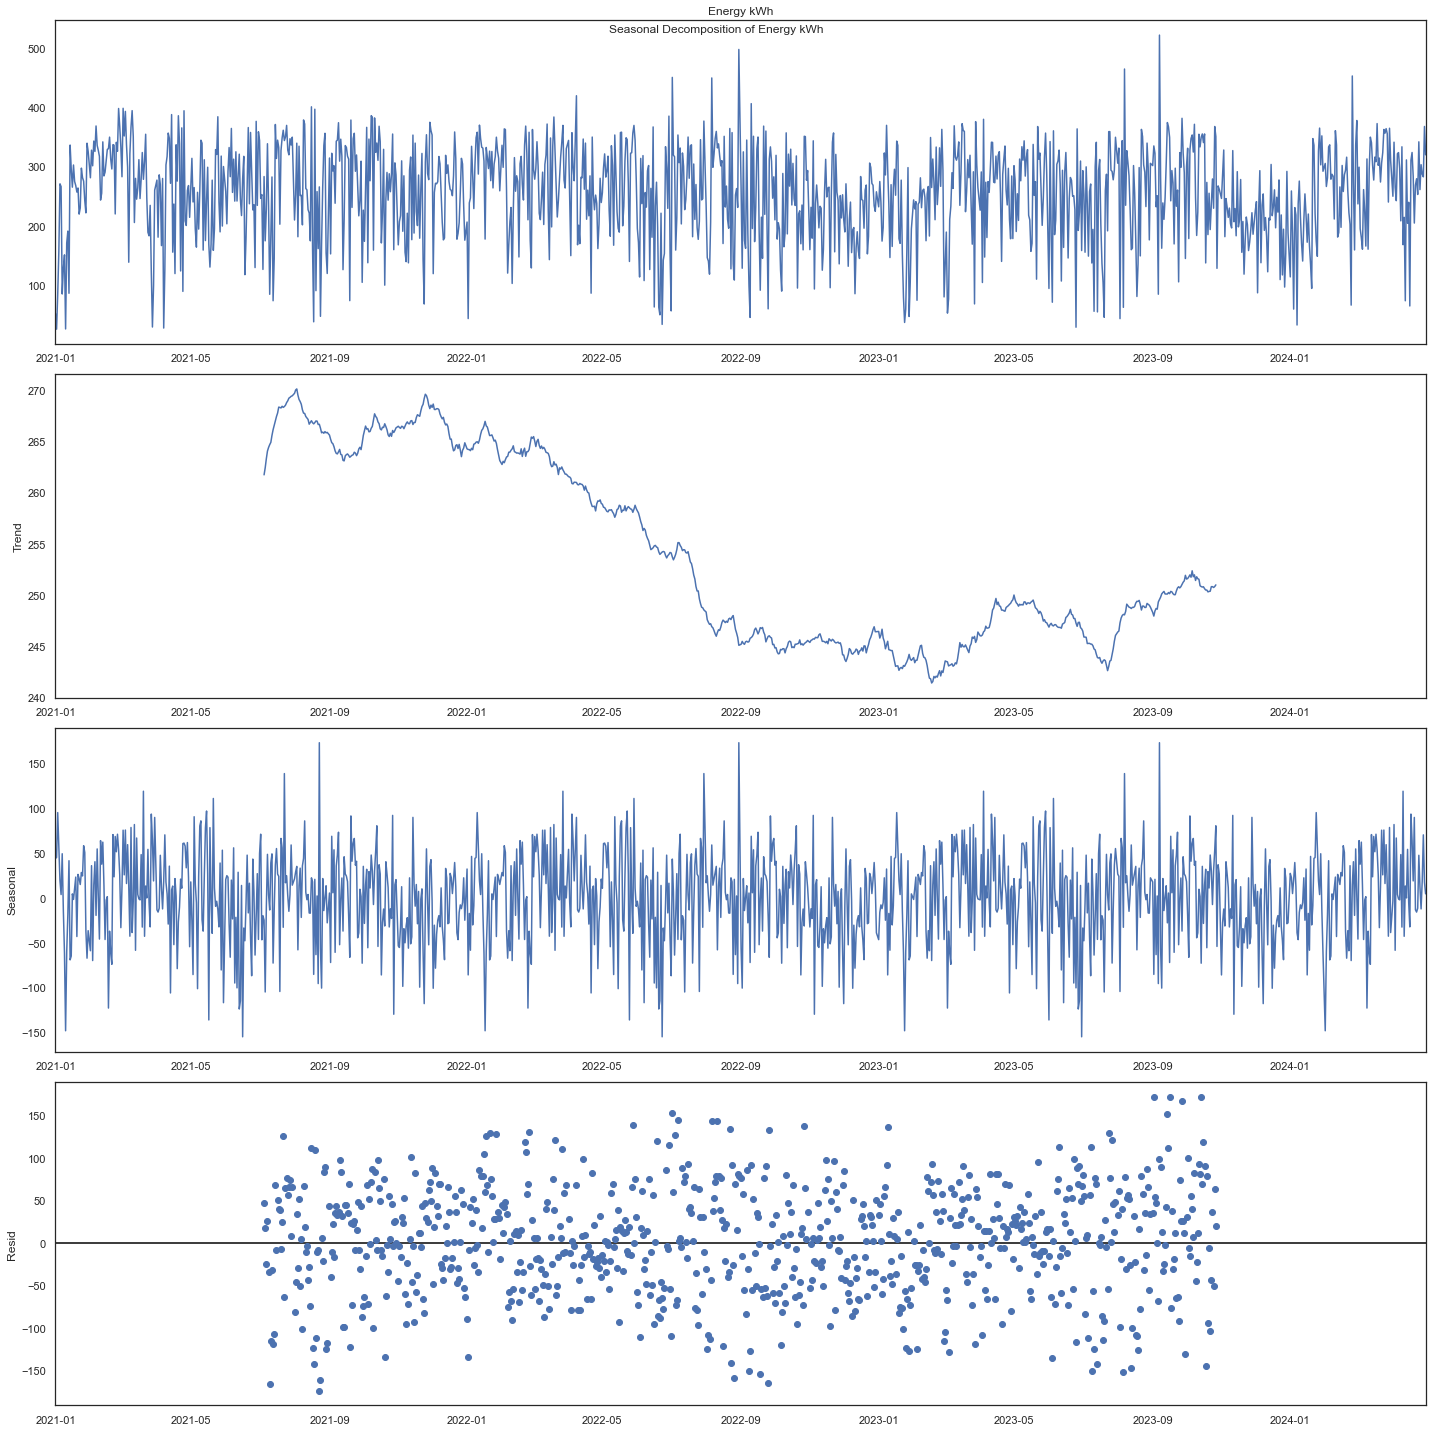

<Figure size 576x576 with 0 Axes>

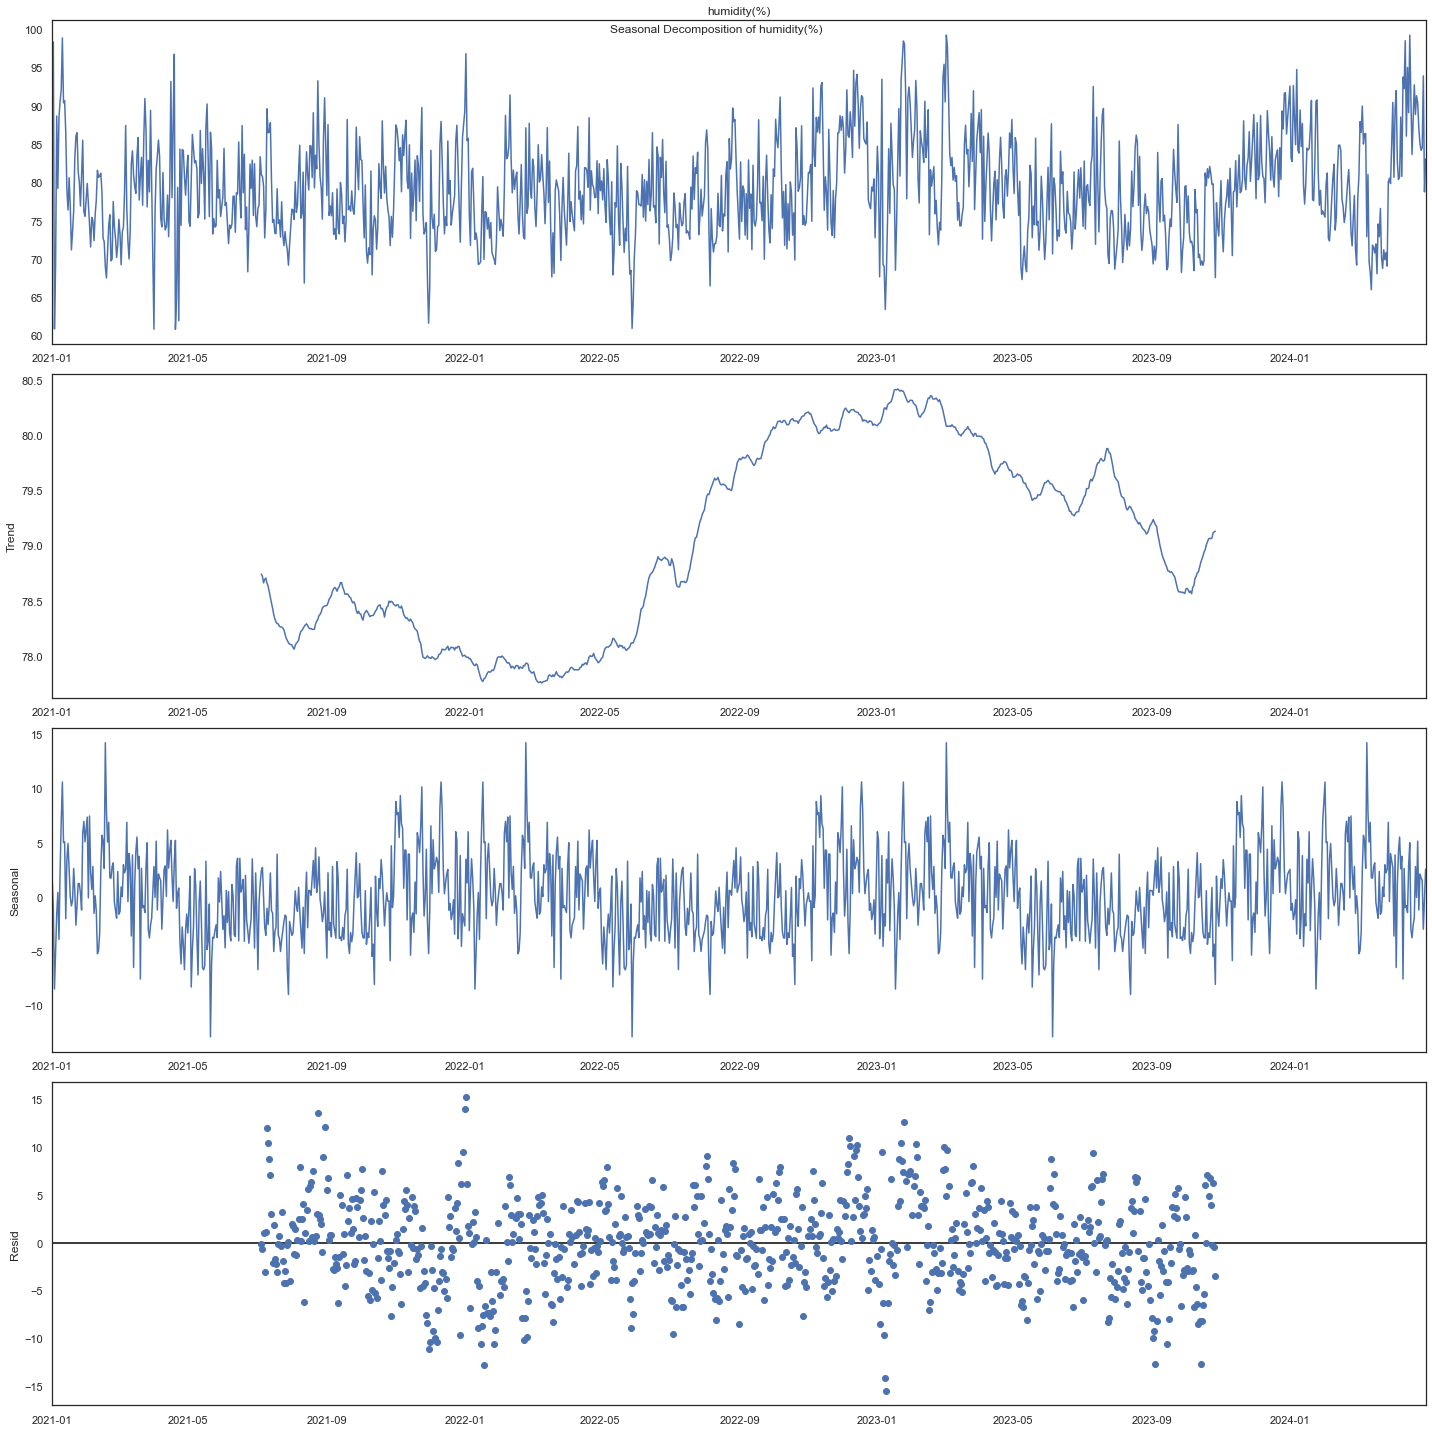

<Figure size 576x576 with 0 Axes>

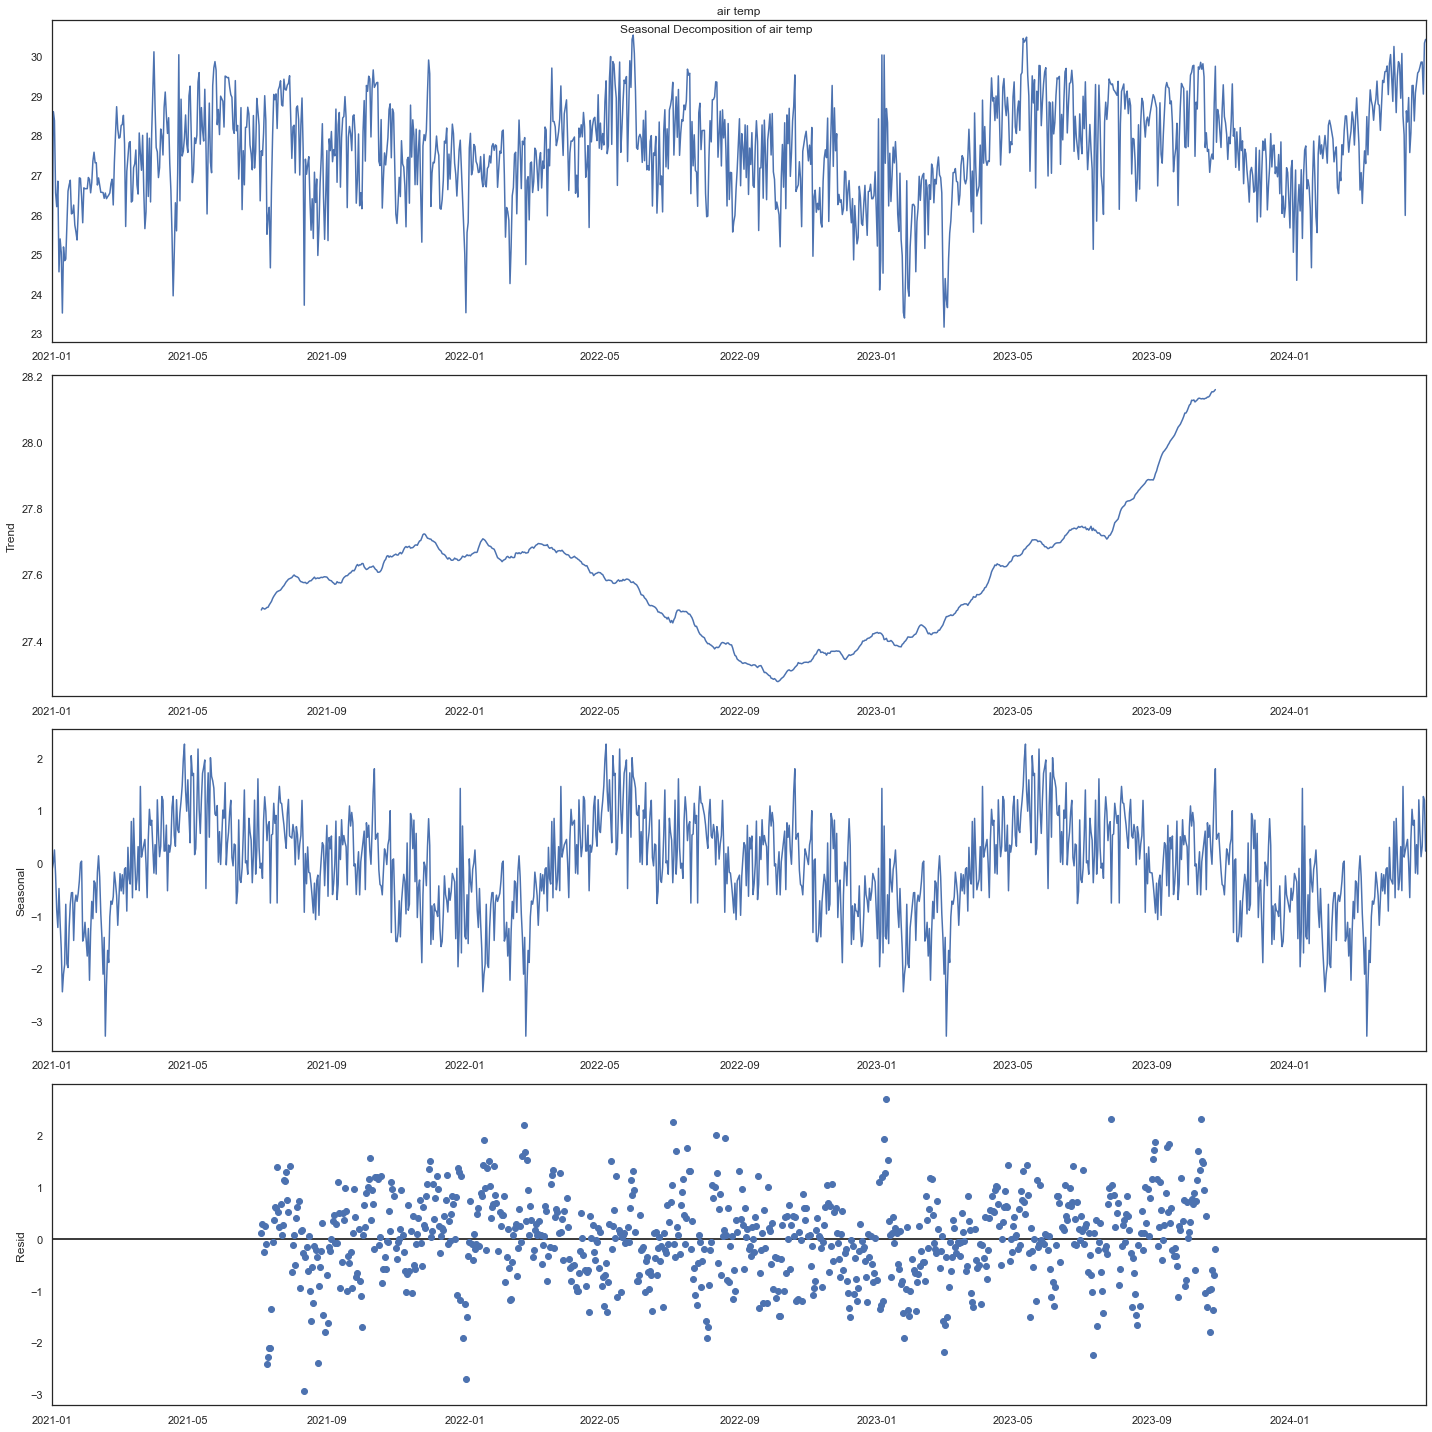

<Figure size 576x576 with 0 Axes>

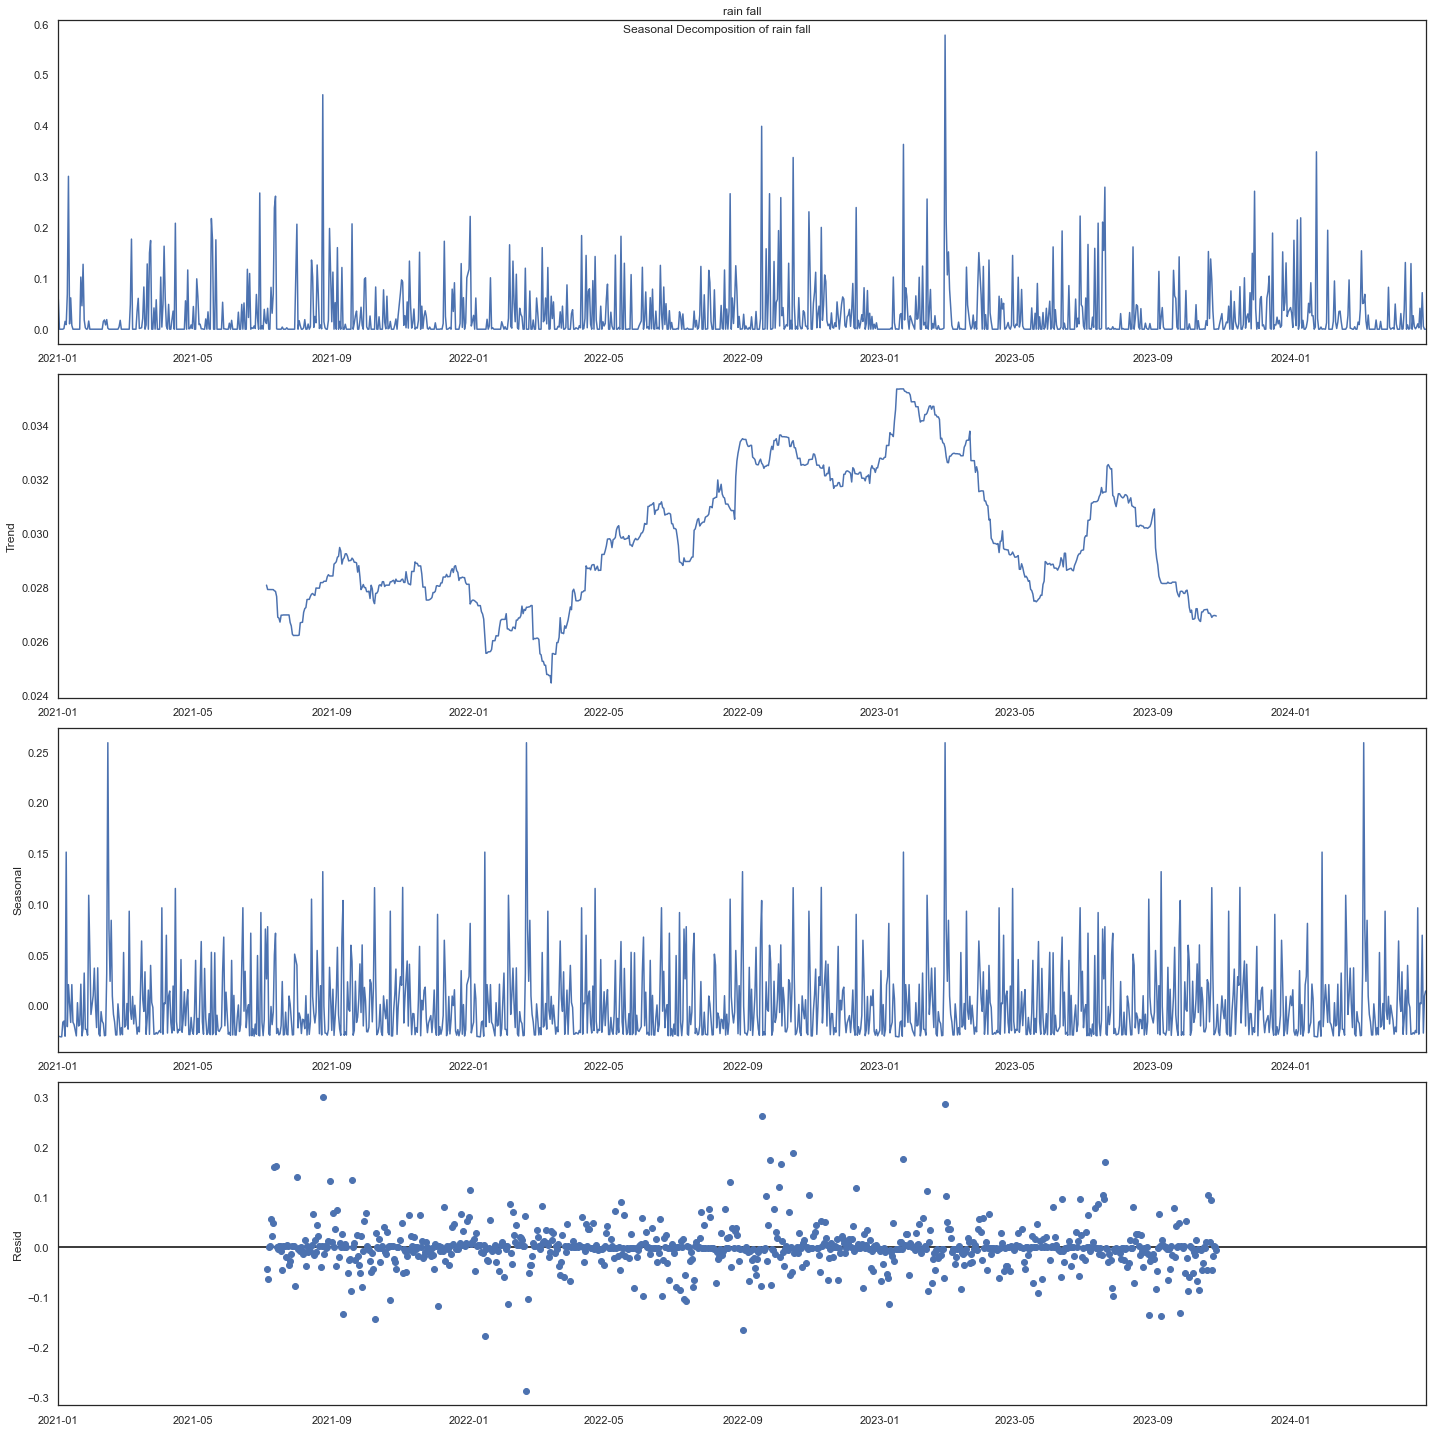

In [16]:
variables=['Energy kWh', 'humidity(%)', 'air temp', 'rain fall']
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 20] 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

for var in variables:
    result = seasonal_decompose(df_forecast[var], model='additive', period=365)
    plt.figure(figsize=(8, 8))  
    result.plot()
    plt.suptitle(f'Seasonal Decomposition of {var}')
    plt.show()


### SARIMAX Model

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
endog = df_forecast['Energy kWh']
exog = df_forecast[['humidity(%)', 'air temp', 'rain fall']]

train_size = int(len(endog) * 0.8)
endog_train, endog_test = endog.iloc[:train_size], endog.iloc[train_size:]
exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

In [18]:
sarimax_model = SARIMAX(endog_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_model_fit = sarimax_model.fit(disp=False)

print(sarimax_model_fit.summary())

C:\Users\Cheong Chun Fai\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Cheong Chun Fai\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Cheong Chun Fai\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         Energy kWh   No. Observations:                  954
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5156.425
Date:                            Wed, 29 May 2024   AIC                          10328.851
Time:                                    06:52:14   BIC                          10367.626
Sample:                                         0   HQIC                         10343.632
                                            - 954                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
humidity(%)    -6.3630      0.521    -12.213      0.000      -7.384      -5.342
air temp       23.8387      2.71

ARIMAX MAE: 41.942835559788186, RMSE: 56.35538898708782


C:\Users\Cheong Chun Fai\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


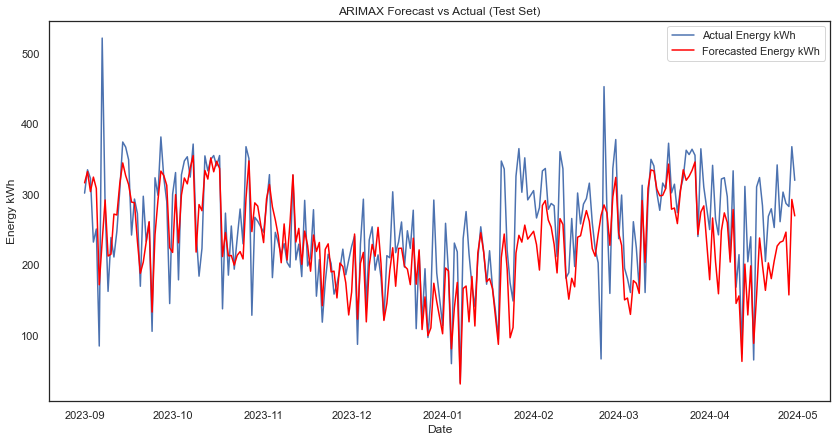

In [19]:
forecast_period = len(endog_test)
forecast = sarimax_model_fit.get_forecast(steps=forecast_period, exog=exog_test)
forecast_values = forecast.predicted_mean


mse_arimax = mean_squared_error(endog_test, forecast_values)
mae_arimax = mean_absolute_error(endog_test, forecast_values)
rmse_arimax = np.sqrt(mse_arimax)

print(f'ARIMAX MAE: {mae_arimax}, RMSE: {rmse_arimax}')

plt.figure(figsize=(14, 7))
plt.plot(endog_test.index, endog_test, label='Actual Energy kWh')
plt.plot(endog_test.index, forecast_values, label='Forecasted Energy kWh', color='red')
plt.xlabel('Date')
plt.ylabel('Energy kWh')
plt.title('ARIMAX Forecast vs Actual (Test Set)')
plt.legend()
plt.show()

C:\Users\Cheong Chun Fai\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


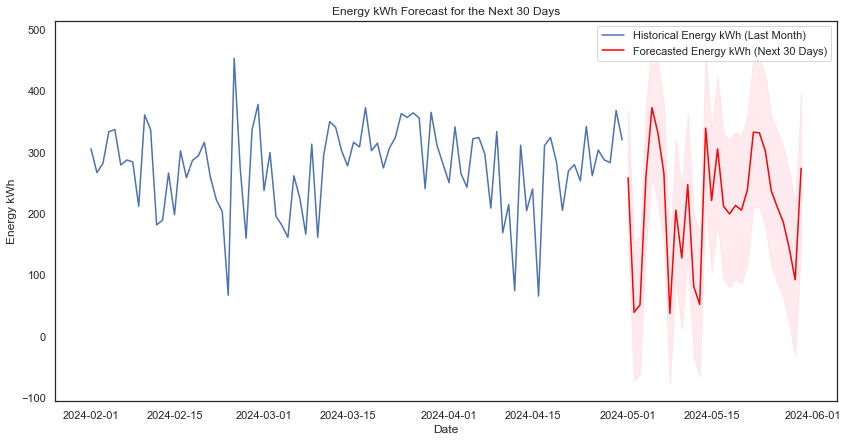

In [20]:
np.random.seed(42)  

### random values of exo data range from min to max
future_exog = pd.DataFrame({
    'humidity(%)': np.random.uniform(low=exog['humidity(%)'].min(), high=exog['humidity(%)'].max(), size=30),
    'air temp': np.random.uniform(low=exog['air temp'].min(), high=exog['air temp'].max(), size=30),
    'rain fall': np.random.uniform(low=exog['rain fall'].min(), high=exog['rain fall'].max(), size=30)
})

# forecast the next 30 days using random exogenous data
forecast_steps = 30
future_forecast = sarimax_model_fit.get_forecast(steps=forecast_steps, exog=future_exog)
future_forecast_values = future_forecast.predicted_mean


confidence_intervals = future_forecast.conf_int()

# date range for the last 3 month of historical data
last_month_start = endog.index[-1] - pd.DateOffset(days=90)

# filter the historical data to include only the last 3 month
historical_last_month = endog[last_month_start:]

plt.figure(figsize=(14, 7))
plt.plot(historical_last_month.index, historical_last_month, label='Historical Energy kWh (Last Month)')
forecast_dates = pd.date_range(start=endog.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
plt.plot(forecast_dates, future_forecast_values, label='Forecasted Energy kWh (Next 30 Days)', color='red')
plt.fill_between(forecast_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Energy kWh')
plt.title('Energy kWh Forecast for the Next 30 Days')
plt.legend()
plt.show()

## Regression Model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [22]:
df = pd.read_excel('final data/estate_soe_combined_api.xlsx')
df = df[df['Sensor Type'] == 'DPM']
df.drop(['Sensor ID','Sensor Type','IRR Value W/m²', 'PR %'], axis=1, inplace=True)

In [23]:
df = df[df['Block'] != 'SOE']
df.drop(['Block'], axis=1, inplace=True)

In [24]:
df = df.groupby(['Month','Day']).mean().reset_index()

In [25]:
X = df[['Month', 'Day', 'rain fall', 'air temp', 'humidity(%)']]
y = df['Energy kWh']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)


# Evaluate the Linear Regression Model using Mean Absolute Error (MAE)
# The lower MAE, the better the model performance
print('train_mae:', mean_absolute_error(y_train, linear_reg.predict(X_train_scaled)), 
      '\n test_mae:', mean_absolute_error(y_test, linear_reg.predict(X_test_scaled)))
print('\n')
# Evaluate the Linear Regression Model using Mean Square Error (MSE)
# The lower MSE, the better the model performance
print('train_mse:', mean_squared_error(y_train, linear_reg.predict(X_train_scaled)), 
      '\n test_mse:', mean_squared_error(y_test, linear_reg.predict(X_test_scaled)))
print('\n')
# Evaluate the Linear Regression Model using R-Square
# The closer the r-square value to 1, the better the model performance
print('train_r-sq:', r2_score(y_train, linear_reg.predict(X_train_scaled)), 
      '\n test_r-sq:', r2_score(y_test, linear_reg.predict(X_test_scaled)))


train_mae: 28.682857703931997 
 test_mae: 21.012365369417985


train_mse: 1283.2892315808103 
 test_mse: 706.2383048408634


train_r-sq: 0.4257342285122927 
 test_r-sq: 0.5434926584271662


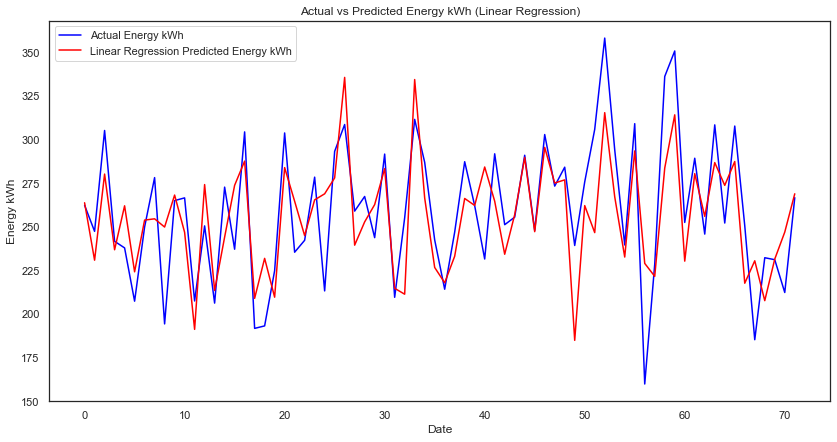

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Energy kWh', color='blue')
plt.plot(linear_reg.predict(X_test_scaled), label='Linear Regression Predicted Energy kWh', color='red')
plt.xlabel('Date')
plt.ylabel('Energy kWh')
plt.title('Actual vs Predicted Energy kWh (Linear Regression)')
plt.legend()
plt.show()

## SOE User Need Threshold Alert model

In [28]:
df = pd.read_excel('final data/soe_combined_api.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62784 entries, 0 to 62783
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         62784 non-null  datetime64[ns]
 1   kW               62784 non-null  float64       
 2   kWh              62784 non-null  float64       
 3   Panel            62784 non-null  object        
 4   humidity(%)      62784 non-null  float64       
 5   air temperature  62784 non-null  float64       
 6   rainfall         62784 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 3.4+ MB


In [29]:
df['Hour'] = df['datetime'].dt.hour
df['Minute'] = df['datetime'].dt.minute
df['Day'] = df['datetime'].dt.day
df['Month'] = df['datetime'].dt.month
df['Dayofweek'] = df['datetime'].dt.dayofweek

In [30]:
# lag features
for lag in range(1, 13):  # previous hour (12*5-minute intervals)
    df[f'kW_lag_{lag}'] = df['kW'].shift(lag)

# rolling window features
df['kW_roll_mean_1h'] = df['kW'].rolling(window=12).mean()  # 1 hour rolling mean
df['kW_roll_std_1h'] = df['kW'].rolling(window=12).std()  # 1 hour rolling std


df.dropna(inplace=True)

In [31]:
df = df[(df['Hour'] >= 9) & (df['Hour'] <= 18)] # include record between 9am - 6pm

In [32]:
features = [col for col in df.columns if col not in ['datetime', 'kW', 'kWh', 'Panel']]
X = df[features]
y = df['kW']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_scaled, y_train)

y_pred_train = rf_reg.predict(X_train_scaled)
y_pred_test = rf_reg.predict(X_test_scaled)

In [34]:
# Evaluate the Linear Regression Model using Mean Absolute Error (MAE)
# The lower MAE, the better the model performance
print('train_mae:', mean_absolute_error(y_train, y_pred_train), 
      '\n test_mae:', mean_absolute_error(y_test, y_pred_test))
print('\n')
# Evaluate the Linear Regression Model using Mean Square Error (MSE)
# The lower MSE, the better the model performance
print('train_mse:', mean_squared_error(y_train, y_pred_train), 
      '\n test_mse:', mean_squared_error(y_test, y_pred_test))
print('\n')
# Evaluate the Linear Regression Model using R-Square
# The closer the r-square value to 1, the better the model performance
print('train_r-sq:', r2_score(y_train, y_pred_train), 
      '\n test_r-sq:', r2_score(y_test, y_pred_test))


train_mae: 0.8892593654434253 
 test_mae: 2.374401146788991


train_mse: 2.4574466194610096 
 test_mse: 16.712766754315748


train_r-sq: 0.969732917015667 
 test_r-sq: 0.7898562833222668


In [35]:
def check_low_power_alert(predictions, threshold=5, interval=24):
    alert = any(pred < threshold for pred in predictions[:interval])
    return alert

future_predictions = rf_reg.predict(X_test_scaled[:24])

alert = check_low_power_alert(future_predictions)
if alert:
    print("Alert: Low power generation predicted in the next 2 hours.")
else:
    print("Power generation is expected to be sufficient.")


Alert: Low power generation predicted in the next 2 hours.
